+++
notebook = true
title = "LargeDeformations: Rigid Body Rotation"
date = "2023-03-01"
author = "Thomas Nagel"
web_subsection = "large-deformations"
+++


<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./RigidBody.ipynb" download="RigidBody.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=RigidBody.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/LargeDeformation/RigidBody/RigidBody.py"><img src="https://img.shields.io/static/v1?label=Source:&message=RigidBody.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/LargeDeformation/RigidBody/RigidBody.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

|<div style="width:330px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:330px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://upload.wikimedia.org/wikipedia/commons/e/e8/TUBAF_Logo.svg" width="300"/></div>|
|---|---|--:|

In this benchmark we test a basic kinematic feature of the finite strain / large
deformations implementation in OpenGeoSys.
An element is subjected to a rigid body rotation. The expected result is a
stress- and strain-free motion.
This is confirmed for the finite-strain implementation while the small-strain
implementation shows phantom strains and stresses.

## Basic definitions

The small deformation code uses the linearized strain tensor:

\begin{align}
    \boldsymbol{\epsilon} = \frac{1}{2} \left( \text{grad}\, \mathbf{u} + \text{grad}\,^\text{T} \mathbf{u} \right)
\end{align}

while the large deformation code is set up in a Total Lagrangian formulation and
rests on Green-Lagrange strains:

\begin{align}
    \mathbf{E} = \frac{1}{2} \left( \text{Grad}\, \mathbf{U} + \text{Grad}^\text{T} \mathbf{U} + \text{Grad}^\text{T} \mathbf{U}\,\text{Grad}\, \mathbf{U}\right)
\end{align}

A rigid body rotation in 2D can be described by

\begin{align}
    \mathbf{u} = [X_1 (\cos \vartheta - 1) - X_2 \sin \vartheta] \mathbf{E}_1 + [X_1 \sin \vartheta + X_2 (\cos \vartheta - 1)]\mathbf{E}_2
\end{align}

While this yields $\mathbf{E} = \mathbf{0}$ in finite deformation kinematics, we
obtain a linearized strain tensor coordinate matrix with

\begin{align}
    [\boldsymbol{\epsilon}]_{ij} = \left(
            \begin{array}{cc}
                \cos \vartheta - 1 & 0
                \\
                0 & \cos \vartheta - 1
            \end{array}
        \right)
\end{align}

For both cases the OGS's linear elastic model is used to compute stresses. In
the TL formulation this amounts to a Saint-Venant-Kirchhoff model.
It thus suffices to illustrate the behaviour of strain values.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pyvista as pv

# Some plot settings
plt.style.use("seaborn-v0_8-deep")
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.color"] = "black"
plt.rcParams["legend.frameon"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["font.size"] = 14
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["figure.figsize"] = (8, 6)

In [2]:
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)

In [3]:
model_s = ot.Project(
    input_file="square_1e0.prj", output_file=f"{out_dir}/square_1e0_small.prj"
)
model = ot.Project(input_file="square_1e0.prj", output_file="square_1e0.prj")

In [4]:
model_s.replace_text("SMALL_DEFORMATION", xpath="./processes/process/type")
model_s.replace_text(
    "StandardElasticityBrick",
    xpath="./processes/process/constitutive_relation/behaviour",
)
model_s.replace_text("square_1e0_small", xpath="./time_loop/output/prefix")
model_s.remove_element(
    xpath="./processes/process/secondary_variables/secondary_variable[@name='deformation_gradient']"
)
model_s.remove_element(
    xpath="./processes/process/secondary_variables/secondary_variable[@name='volume_ratio']"
)
model_s.remove_element(xpath=".//vtkdiff[field='deformation_gradient']")
model_s.remove_element(xpath=".//vtkdiff[field='volume_ratio']")
model_s.write_input()

In [5]:
model.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir}")
model_s.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir} -m .")

Project file written to output.
Simulation: square_1e0.prj
Status: finished successfully.
Execution took 0.22890424728393555 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/RigidBody/RigidBody/square_1e0_small.prj
Status: finished successfully.
Execution took 0.21960663795471191 s


In [6]:
pv.set_plot_theme("document")
pv.set_jupyter_backend("static")  # comment out for interactive graphics

In [7]:
reader = pv.get_reader(f"{out_dir}/square_1e0.pvd")
reader_s = pv.get_reader(f"{out_dir}/square_1e0_small.pvd")

In [8]:
reader.set_active_time_value(0.0)
reader_s.set_active_time_value(0.0)
mesh = reader.read()[0]  # nulltes Gitter lesen
mesh_s = reader_s.read()[0]  # nulltes Gitter lesen

In [9]:
points = mesh.point_data["epsilon"].shape[0]

In [10]:
xs = mesh.points[:, 0]
ys = mesh.points[:, 1]

In [11]:
def ploteps(time, angle, quantity="epsilon"):
    reader.set_active_time_value(time)
    reader_s.set_active_time_value(time)
    mesh = reader.read()[0]  # nulltes Gitter lesen
    mesh_s = reader_s.read()[0]  # nulltes Gitter lesen
    eps_vec = mesh.point_data[quantity][:, 0]
    eps_vec_s = mesh_s.point_data[quantity][:, 0]

    print(
        "Expected: %.2f (small strain) and 0 (large strain)"
        % (np.cos(np.deg2rad(angle)) - 1)
    )

    sargs = {
        "title": "small deformation, " + str(angle) + "°",
        "title_font_size": 15,
        "label_font_size": 15,
        "n_labels": 2,
        "position_x": 0.2,
        "position_y": 0.85,
        "fmt": "%.1f",
        "width": 0.6,
    }

    p = pv.Plotter(shape=(1, 2), border=False)
    p.subplot(0, 0)
    p.add_mesh(
        mesh,
        scalars=eps_vec_s,
        show_edges=False,
        show_scalar_bar=True,
        colormap="RdBu_r",
        scalar_bar_args=sargs,
    )
    # p.show_bounds(ticks="outside", xlabel="", ylabel="")
    # p.add_axes()
    p.view_xy()
    p.camera.zoom(1.2)

    sargs1 = {
        "title": "large deformation, " + str(angle) + "°",
        "title_font_size": 15,
        "label_font_size": 15,
        "n_labels": 2,
        "position_x": 0.2,
        "position_y": 0.85,
        "fmt": "%.1f",
        "width": 0.6,
    }

    p.subplot(0, 1)
    p.add_mesh(
        mesh,
        scalars=eps_vec,
        show_edges=False,
        show_scalar_bar=True,
        colormap="RdBu_r",
        scalar_bar_args=sargs1,
    )
    # p.show_bounds(ticks="outside", xlabel="", ylabel="")
    # p.add_axes()
    p.view_xy()
    p.camera.zoom(1.2)

    p.window_size = [800, 400]
    p.show()

We plot the normal strain in the $x$-direction for both kinematic formulations
on the *undeformed* configuration as it undergoes a 360° rotation and find our
expectations confirmed.

Expected: 0.00 (small strain) and 0 (large strain)


2025-10-30 14:43:37.612 (   1.254s) [    7F6087281400]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=
/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/.venv/lib/python3.13/site-packages/pyvista/plotting/mapper.py:675: RuntimeWarning: All-NaN axis encountered
  clim = [np.nanmin(scalars), np.nanmax(scalars)]


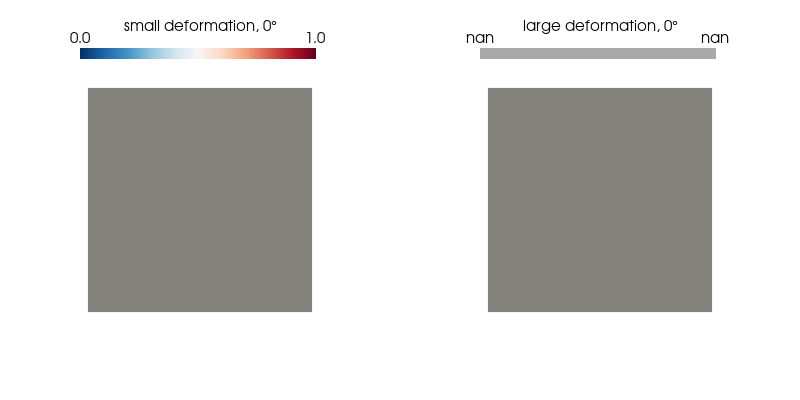

In [12]:
ploteps(0, 0)

Expected: -0.29 (small strain) and 0 (large strain)


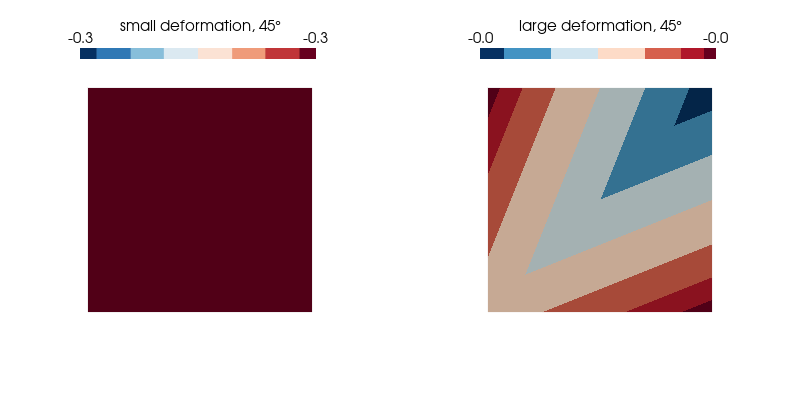

In [13]:
ploteps(0.5, 45)

Expected: -1.00 (small strain) and 0 (large strain)


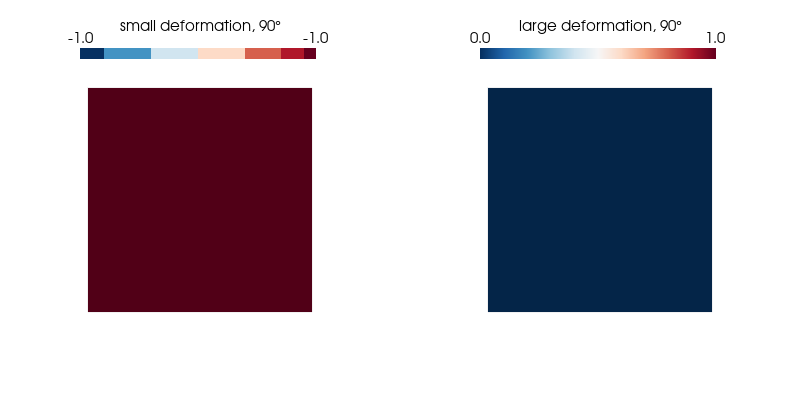

In [14]:
ploteps(1, 90)

Expected: -2.00 (small strain) and 0 (large strain)


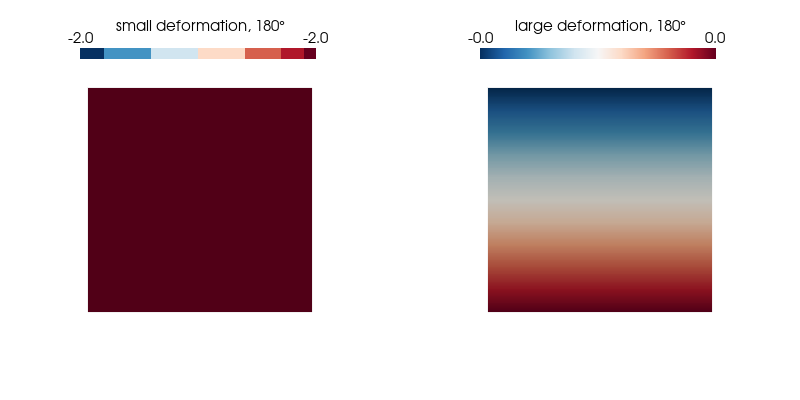

In [15]:
ploteps(2, 180)

Expected: -1.00 (small strain) and 0 (large strain)


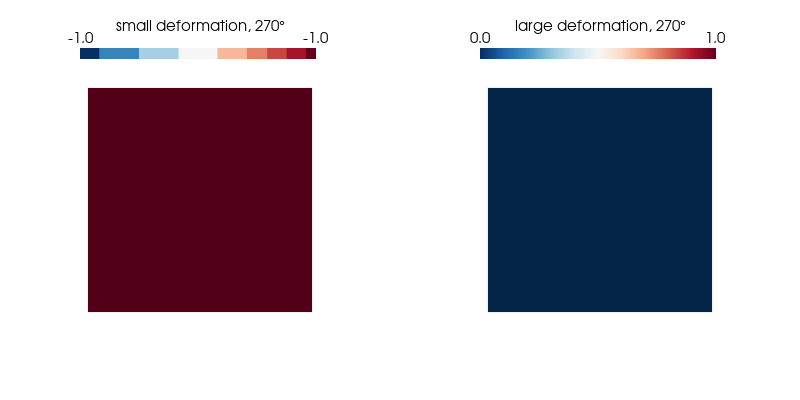

In [16]:
ploteps(3, 270)

Expected: 0.00 (small strain) and 0 (large strain)


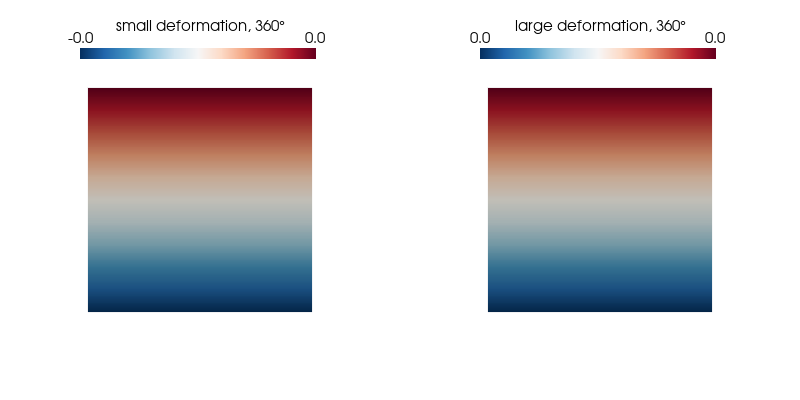

In [17]:
ploteps(4, 360)